In [2]:
import Pkg; Pkg.activate("..")

  Activating project at `~/SAFT_ML`


In [3]:
using CSV, DataFrames, DelimitedFiles, Clapeyron, PyCall, BSON
import PyPlot; const plt = PyPlot ;

In [31]:
raw_data = CSV.read("SI_pcp-saft_parameters.csv",DataFrame,header=1) ;
fieldnames(typeof(raw_data))
#display(names(df)[1:20]) ;
writedlm("out.txt", names(raw_data), ' ') ;

replace!(raw_data.mu, missing => 0) ;
replace!(raw_data.kappa_ab, missing => 0) ;
replace!(raw_data.epsilon_k_ab, missing => 0) ;

raw_data.mu = Float64.(raw_data.mu)
raw_data.kappa_ab = Float64.(raw_data.kappa_ab)
raw_data.epsilon_k_ab = Float64.(raw_data.epsilon_k_ab) ;
raw_data = sort(raw_data, :molarweight) ;

In [32]:
num_rows = nrow(raw_data)
processed_data = DataFrame(
    species = fill(missing, num_rows),
    isomeric_SMILES = fill(missing, num_rows), 
    family = fill(missing, num_rows),
    Mw = fill(missing, num_rows),
    segment = fill(missing, num_rows),
    sigma = fill(missing, num_rows),
    epsilon = fill(missing, num_rows),
    dipole = fill(missing, num_rows),
    kappa_ab = fill(missing, num_rows),
    epsilon_k_ab = fill(missing, num_rows),
    na = fill(missing, num_rows),
    nb = fill(missing, num_rows),
    interaction = fill(missing,num_rows),
    bounds_violation = fill(missing,num_rows),
    source = fill(missing, num_rows)
) ;

In [33]:
processed_data.species = raw_data.common_name
processed_data.Mw = raw_data.molarweight
processed_data.isomeric_SMILES = raw_data.isomeric_smiles
processed_data.family = raw_data.family
processed_data.segment = raw_data.m
processed_data.sigma = raw_data.sigma
processed_data.epsilon = raw_data.epsilon_k
processed_data.dipole = raw_data.mu
processed_data.kappa_ab = raw_data.kappa_ab
processed_data.epsilon_k_ab = raw_data.epsilon_k_ab
processed_data.na = raw_data.na
processed_data.nb = raw_data.nb
processed_data.interaction = raw_data.opt
processed_data.bounds_violation = raw_data.bounds_violation
processed_data[!, :source] .= "10.1021/acs.iecr.3c02255" ;

species_names = processed_data.species ;
# processed_data = processed_data[1:1843,:] ;
filter!(row -> row.species != "cis-2-butene", processed_data)
filter!(row -> row.species != "(cis/trans)-2-butene", processed_data)
filter!(row -> row.species != "cis-2-pentene", processed_data)

processed_data


Row,species,isomeric_SMILES,family,Mw,segment,sigma,epsilon,dipole,kappa_ab,epsilon_k_ab,na,nb,interaction,bounds_violation,source
,String,String,String31,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,String15,String,String
1,methane,C,Alkanes,16.031,1.0,3.70051,150.071,0.0,0.0,0.0,0,0,NONPOLAR,m: lower,10.1021/acs.iecr.3c02255
2,ammonia,N,Inorganic compounds,17.027,2.44608,2.3709,213.571,0.0,0.0001,200.0,1,1,ASSOCIATIVE,"kappa_ab: lower, epsilon_k_ab: lower",10.1021/acs.iecr.3c02255
3,ammonia-d3,[2H]N([2H])[2H],Other compounds,17.027,2.77559,2.0918,129.266,0.0,0.9,1233.56,1,1,ASSOCIATIVE,kappa_ab: higher,10.1021/acs.iecr.3c02255
4,water,O,Inorganic compounds,18.011,2.36948,2.15072,230.716,0.0,0.35319,2195.1,1,1,ASSOCIATIVE,OK,10.1021/acs.iecr.3c02255
5,tritium oxide,[3H]O[3H],Other compounds,18.011,2.63111,1.99608,344.334,0.0,0.0,0.0,0,0,NONPOLAR,OK,10.1021/acs.iecr.3c02255
6,hydrogen fluoride,F,Inorganic compounds,20.006,1.23675,2.90791,322.584,1.82,0.0,0.0,0,0,DIPOLAR,OK,10.1021/acs.iecr.3c02255
7,ethyne,C#C,Alkynes,26.016,2.22087,2.87502,166.034,0.0,0.0,0.0,0,0,NONPOLAR,OK,10.1021/acs.iecr.3c02255
8,hydrogen cyanide,C#N,Nitriles,27.011,2.72334,2.64506,170.345,2.98,0.0,0.0,1,0,DIPOLAR,OK,10.1021/acs.iecr.3c02255
9,carbon monoxide,[C-]#[O+],Inorganic compounds,27.995,1.32286,3.24532,91.1709,0.0,0.0,0.0,0,0,NONPOLAR,OK,10.1021/acs.iecr.3c02255


In [90]:
num_rows = nrow(processed_data)
training_data = DataFrame(
    species = fill(missing, num_rows),
    isomeric_SMILES = fill(missing, num_rows), 
    family = fill(missing, num_rows),
    Mw = fill(missing, num_rows),
    interaction = fill(missing,num_rows),
    source = fill(missing, num_rows),
    critical_temperature_K = fill(0,num_rows),
    critical_pressure_MPa = fill(0,num_rows),
    critical_volume_m3_per_mol = fill(0,num_rows),
    sat_temperatures_K = fill([0.0],num_rows),
    sat_pressures_MPa = fill([0.0],num_rows),
    sat_volumes_liq_m3_per_mol = fill([0.0],num_rows),
    sat_volumes_vap_m3_per_mol = fill([0.0],num_rows)
) ;

training_data.species = processed_data.species
training_data.isomeric_SMILES = processed_data.isomeric_SMILES
training_data.family = processed_data.family
training_data.Mw = processed_data.Mw
training_data.interaction = processed_data.interaction
training_data.source = processed_data.source ;

training_data.critical_temperature_K = Float64.(training_data.critical_temperature_K)
training_data.critical_pressure_MPa = Float64.(training_data.critical_pressure_MPa)
training_data.critical_volume_m3_per_mol = Float64.(training_data.critical_volume_m3_per_mol) ;


In [91]:
# Check number of functional groups in dataset
unique_values = unique(processed_data[!, :family])
num_unique_values = length(unique_values)
println(unique_values)

String31["Alkanes", "Inorganic compounds", "Other compounds", "Alkynes", "Nitriles", "Elements", "Alkenes", "Aldehydes", "Amines", "Silanes/siloxanes", "Alcohols", "Fluorides", "Cyclic compounds", "Acids", "Ethers", "Thiols", "Chlorides", "Ketones", "Polyfunctional compounds", "Sulfides/thiophenes", "Esters", "Aromatic hydrocarbons", "Halogenated compounds"]


In [93]:
# This cell generates data for all ~1800 species in Esper et al.
num_rows = nrow(processed_data)

n = 500

for i in species_names

    row_number = findall(processed_data.species .== i)[1]
    println(row_number," ",i)

    model = PPCSAFT(i) ;
    critical_props = crit_pure(model)

    temp_range = collect(range(0.5*critical_props[1],critical_props[1],n)) ;
    sat_props = [saturation_pressure(model,temp_range[i]) for i ∈ 1:n] ;

    sat_pressures = [sat_props[i][1] for i ∈ 1:n] ;
    sat_vols_liq = [sat_props[i][2] for i ∈ 1:n] ;
    sat_vols_vap = [sat_props[i][3] for i ∈ 1:n] ;

    for i in 1:length(critical_props)
        training_data[row_number, 6 + i] = critical_props[i]
    end

    training_data[row_number,:sat_temperatures_K] = temp_range
    training_data[row_number,:sat_pressures_MPa] = sat_pressures
    training_data[row_number,:sat_volumes_liq_m3_per_mol] = sat_vols_liq
    training_data[row_number,:sat_volumes_vap_m3_per_mol] = sat_vols_vap

end


1 methane
2 ammonia
3 ammonia-d3
4 water
5 tritium oxide
6 hydrogen fluoride
7 ethyne
8 hydrogen cyanide
9 carbon monoxide
10 nitrogen
11 ethylene
12 ethylene-d4
13 nitrogen oxide
14 formaldehyde
15 ethane
16 methylamine
17 oxygen
18 silane
19 methanol
20 o-deuteromethanol
21 hydrazine
22 hydrogen sulfide
23 deuterium sulfide
24 phosphorous trihydride
25 hydrogen peroxide
26 methyl fluoride
27 hydrogen chloride
28 fluorine
29 argon
30 propyne
31 propadiene
32 acetonitrile
33 propylene
34 cyclopropane
35 ethylenimine
36 carbon dioxide
37 dinitrogen monoxide
38 acetaldehyde
39 ethylene oxide
40 propane
41 formamide
42 dimethylamine
43 ethylamine
44 nitrogen dioxide
45 formic acid
46 ethanol
47 dimethyl ether
48 methylhydrazine
49 ozone
50 methanethiol
51 fluoroethane
52 methyl chloride
53 cyanogen
54 difluoromethane
55 1-buten-3-yne
56 acrylonitrile
57 1,3-butadiene
58 2-butyne
59 1-butyne
60 propionitrile
61 acrolein
62 2-propyn-1-ol
63 1-butene
64 trans-2-butene
65 isobutylene
66 cyclo

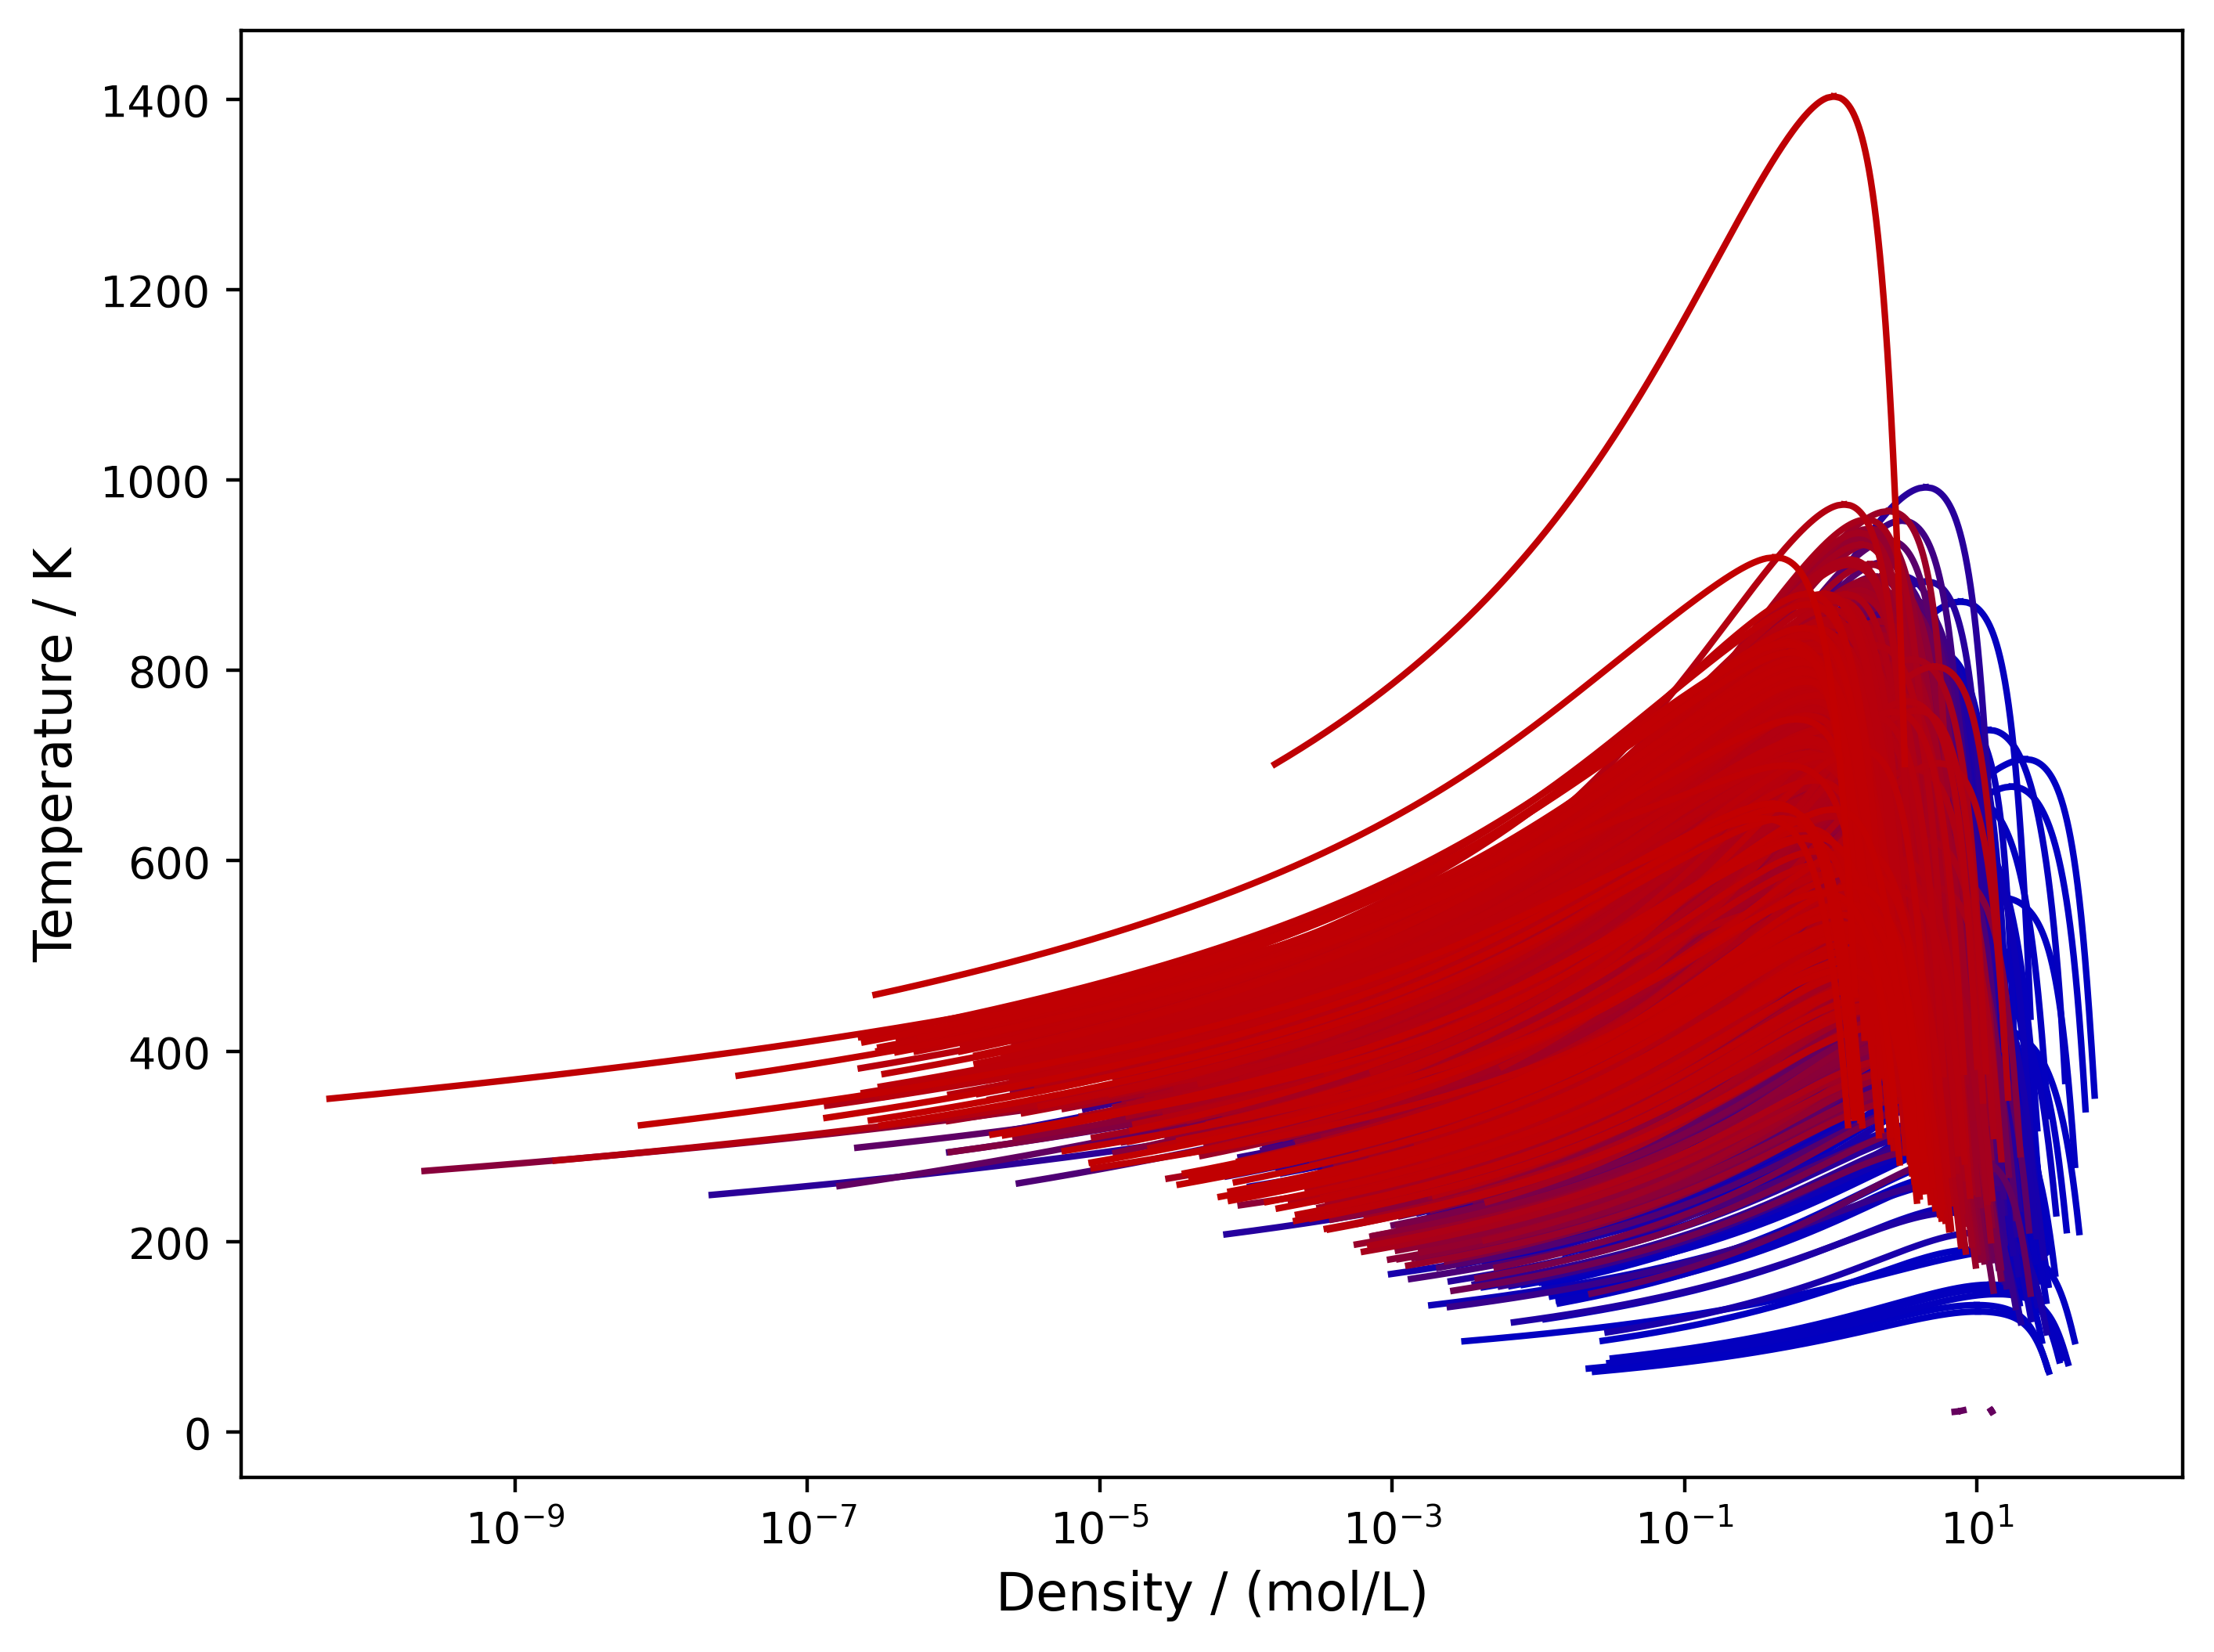

In [ ]:
colour_grad_1 = collect(range(1,194,length(species_names)) ./255) 
colour_grad_2 = collect(range(194,1,length(species_names)) ./255)

plt.figure(figsize=(8, 6), dpi=400)

for i = 1:length(species_names)

plt.semilogx(1e-3 ./training_data[i,12],training_data[i,10], color = [colour_grad_1[i] 0 colour_grad_2[i]])
plt.semilogx(1e-3 ./training_data[i,13],training_data[i,10],color = [colour_grad_1[i] 0 colour_grad_2[i]])

end

# plt.legend(loc="lower right",bbox_to_anchor =(-0.1,-0.05),frameon=false,fontsize=8,ncol=3) 
plt.xlabel("Density / (mol/L)",fontsize=12)
plt.ylabel("Temperature / K",fontsize=12)

plt.savefig("all_compound_phase_envelopes.png",dpi=400)


In [4]:
# Data storage
CSV.write("training_data.csv", training_data) ;

LoadError: UndefVarError: `training_data` not defined

In [23]:
# Load CSV training data and convert to a dataframe with appropriate data types
training_data = CSV.read("training_data.csv",DataFrame) ;
num_rows = nrow(training_data)

sat_temp_strings = training_data.sat_temperatures_K
sat_pressure_strings = training_data.sat_pressures_MPa
sat_vol_liq_strings = training_data.sat_volumes_liq_m3_per_mol
sat_vol_vap_strings = training_data.sat_volumes_vap_m3_per_mol

select!(training_data, Not(:sat_temperatures_K),Not(:sat_pressures_MPa),Not(:sat_volumes_liq_m3_per_mol),Not(:sat_volumes_vap_m3_per_mol))

training_data.sat_pressures_MPa = fill([0.0],num_rows) ;
training_data.sat_volumes_liq_m3_per_mol = fill([0.0],num_rows) ;
training_data.sat_volumes_vap_m3_per_mol = fill([0.0],num_rows) ;
training_data.sat_temperatures_K = fill([0.0],num_rows) ;

# Fix data type for saturation temperatures

for j in [sat_temp_strings, sat_pressure_strings, sat_vol_liq_strings, sat_vol_vap_strings]
    for i = 1:num_rows

        string_sq_brackets_removed = replace(j[i], r"[][]" => "" )
        vector_of_floats = [parse(Float64, val) for val in split(string_sq_brackets_removed, ",")]

        if j == sat_temp_strings
            training_data[i,:sat_temperatures_K] = vector_of_floats
        elseif j == sat_pressure_strings
            training_data[i,:sat_pressures_MPa] = vector_of_floats 
        elseif j == sat_vol_vap_strings
            training_data[i,:sat_volumes_vap_m3_per_mol] = vector_of_floats
        elseif j == sat_vol_liq_strings
            training_data[i,:sat_volumes_liq_m3_per_mol] = vector_of_floats
        end

    end
end


In [37]:
training_data = CSV.read("training_data.csv",DataFrame)
num_rows = nrow(training_data)
rename!(training_data,:sat_temperatures_K=>:sat_temp_strings, :sat_pressures_MPa=>:sat_pressure_strings,
        :sat_volumes_liq_m3_per_mol=>:sat_vol_liq_strings,:sat_volumes_vap_m3_per_mol=>:sat_vol_vap_strings)

# Define the column names
array_cols_to_create = [:sat_temperatures_K, :sat_pressures_MPa, :sat_volumes_liq_m3_per_mol, :sat_volumes_vap_m3_per_mol]
string_columns = [:sat_temp_strings, :sat_pressure_strings, :sat_vol_liq_strings, :sat_vol_vap_strings]

# Initialize the columns with zeros
for col in columns_to_process
    training_data[!, col] .= fill([0.0], num_rows)
end

# Process and assign the values to the DataFrame
for (col, str_col) in zip(columns_to_process, string_columns)
    for i = 1:num_rows
        string_sq_brackets_removed = replace(training_data[i, str_col], r"[][]" => "")
        vector_of_floats = [parse(Float64, val) for val in split(string_sq_brackets_removed, ",")]
        training_data[i, col] = vector_of_floats
    end
end

# Remove the string columns
select!(training_data, Not(string_columns...)) ;